In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.datasets import AirPassengersDataset
%cd ..
%ls

/home/mahdigilany/offline_codes/codes/ts_snr
configs/     logs/    notebooks/  README.md         scripts/
darts_logs/  main.py  OLD/        requirements.txt  src/


In [2]:
from src.modeling.models.deep_time import DeepTIMeModel
from torchmetrics import MetricCollection, MeanAbsolutePercentageError

mape = MeanAbsolutePercentageError()
metrics = MetricCollection([mape])

model = DeepTIMeModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=0,
    batch_size=32,
    datetime_feats=0,
    save_checkpoints=True,
    torch_metrics=metrics,
    pl_trainer_kwargs={"num_sanity_val_steps": 0},
    model_name="deep_time",
    force_reset=True,
    )

/home/mahdigilany/anaconda3/envs/borealis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# import eino
# x = torch.Tensor(np.random.rand(32, 24, 1))
# # y = torch.Tensor(np.random.rand(32, 12, 1))
# # x_time = torch.Tensor(einops.repeat(np.linspace(1, 24, 24), 't -> b t 1', b=32))
# # y_time = torch.Tensor(einops.repeat(np.linspace(1, 12, 12), 't -> b t 1', b=32))
# # x_time = torch.ones(32, 24, 0)
# # y_time = torch.ones(32, 12, 0)
# pl_model = model._create_model(x)
# # preds = pl_model.forward(x, x_time, y_time)
# preds = pl_model.forward((x,None))
# preds.shape

In [4]:
from src.data.registry.data_registry import create_dataset
train_ts, val_ts, scaler = create_dataset('air_passengers') # TimeSeries class object

In [5]:
# train_ts.plot(label='train')
# val_ts.plot(label='val')

In [6]:
model.fit(train_ts, verbose=True, epochs=50, num_loader_workers=0, val_series=val_ts)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | inr              | INR              | 1.3 M 
4 | adaptive_weights | RidgeRegressor   | 1     
------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.258     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  4.95it/s, train_loss=0.0344]

/home/mahdigilany/anaconda3/envs/borealis/lib/python3.9/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


Epoch 1: 100%|██████████| 3/3 [00:00<00:00, 150.08it/s, train_loss=0.0295, val_loss=0.133, val_MeanAbsolutePercentageError=0.244, train_MeanAbsolutePercentageError=0.506]

/home/mahdigilany/anaconda3/envs/borealis/lib/python3.9/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 98.22it/s, train_loss=0.00393, val_loss=0.0688, val_MeanAbsolutePercentageError=0.239, train_MeanAbsolutePercentageError=0.144] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 57.78it/s, train_loss=0.00393, val_loss=0.0688, val_MeanAbsolutePercentageError=0.239, train_MeanAbsolutePercentageError=0.144]


DeepTIMeModel(datetime_feats=0, layer_size=256, inr_layers=5, n_fourier_feats=4096, scales=[0.01, 0.1, 1, 5, 10, 20, 50, 100], input_chunk_length=24, output_chunk_length=12, random_state=0, batch_size=32, save_checkpoints=True, torch_metrics=MetricCollection(
  (MeanAbsolutePercentageError): MeanAbsolutePercentageError()
), pl_trainer_kwargs={'num_sanity_val_steps': 0}, model_name=deep_time, force_reset=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.09it/s]
Mean absolute percentage error: 53.51%.
Mean absolute percentage error: 40.28%.


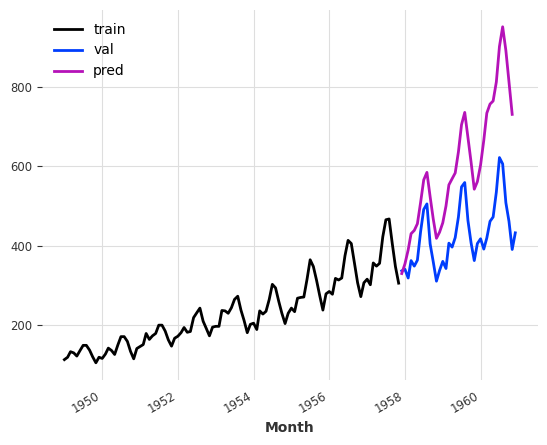

In [7]:
# model.load_from_checkpoint("deep_time", best=True)
model.load_weights_from_checkpoint
pred = model.predict(series=train_ts, n=36)

from darts.metrics import mape as mape_fn
print(
    "Mean absolute percentage error: {:.2f}%.".format(
        mape_fn(val_ts, pred)
    )
)

# scale back:
train_unscaled_ts = scaler.inverse_transform(train_ts)
val_unscaled_ts = scaler.inverse_transform(val_ts)
pred = scaler.inverse_transform(pred)

from darts.metrics import mape as mape_fn
print(
    "Mean absolute percentage error: {:.2f}%.".format(
        mape_fn(val_unscaled_ts, pred)
    )
)

train_unscaled_ts.plot(label='train')
val_unscaled_ts.plot(label='val')
pred.plot(label='pred')
